<a href="https://colab.research.google.com/github/matthewreader/continuous-learning/blob/main/books/deep-learning-with-pytorch/Deep_Learning_with_PyTorch_Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model Learning as Parameter Estimation** 

We'll take some temperatures in celsius and their corresponding temperature in an unknown unit.  This simple regression problem shows how with enough data, we can estimate what the unknown unit temperature should be given a temperature in celsius.

In [ ]:
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

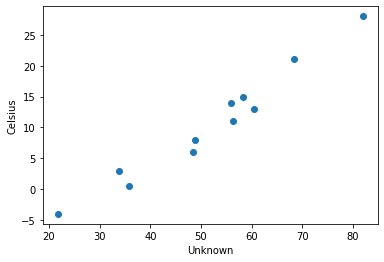

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(t_u, t_c)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.show()

In [ ]:
def model(t_u, w, b):
   return w * t_u + b

def loss_fn(t_p, t_c):
   squared_diffs = (t_p - t_c)**2
   return squared_diffs.mean()  

w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [ ]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

Our above model is pretty useless at this point:

Celsius = (1 * Unknown) + 0

Or Celsius = Unknown, which we know is not true.  We can tweak the weights and bias of our model using PyTorch to create a useful model.  As we tweak out weights, we know we're getting closer to a useful model when we minimize our loss function.

In [ ]:
delta = 0.1

loss_rate_of_change_w = \
   (loss_fn(model(t_u, w + delta, b), t_c) -
    loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

The rate of change in our loss function as we update `w` and `b` might not be uniform as we minimize the loss function.  Therefore we typically make a very small change each time we update these parameters.  This is referred to as the learning rate.

In [ ]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w
w

tensor(-44.1730)

In [ ]:
loss_rate_of_change_b = \
   (loss_fn(model(t_u, w, b + delta), t_c) -
    loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b
b

# Normalize input
t_un = 0.1 * t_u

Learning rates are important because if the learning rate is too large, the updates to parameters could be too large.  This leads to the loss function diverging instead of converging to the minimum.

We may also need to normalize the inputs.  Consider that if the gradient for a weight `w` is greater than the gradient for bias `b`, then they are in differently scaled spaces.

**5.5 - PyTorch autograd and backpropagation**

In [ ]:
# Recall the following for our model and loss functions:
def model(t_u, w, b):
   return w * t_u + b

def loss_fn(t_p, t_c):
   squared_diffs = (t_p - t_c)**2
   return squared_diffs.mean()

# Initialize our parameters with requires_grad=True
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [ ]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

Calling `backward` will lead derivatives to accumulate at leaf nodes.  Gradients should be zeroed explicitly after using it for parameter updates.

In [ ]:
if params.grad is not None:
   params.grad.zero_()

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
 
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
 
        with torch.no_grad():
            params -= learning_rate * params.grad
 
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
 
    return params

In [ ]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)


Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

We could use other optimizers other than gradient descent.  Gradient descent works well enough for our simple problem, but another optimizer might work better for more complicated problems.

In [ ]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

Create `params` and instantiate a gradient descent optimizer

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

Using out stochastic gradient descent optimizer, making sure to zero our gradients each epoch.

In [ ]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)